#### 한글-영어 신경망기계번역: Seq2Seq

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Read Data

In [32]:
import pandas as pd
file_path ="https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/kor_eng.txt"
df=pd.read_csv(file_path, names=['eng','kor','cc'], sep="\t")

In [33]:
df.sample(5)

,eng,kor,cc
3435,Tom turned off his computer.,톰은 자기 컴퓨터를 껐어.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3459,Why are you walking so fast?,왜 그렇게 빨리 걸어?,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
2778,Tom doesn't like to lose.,톰은 지기 싫어한다.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
5521,My favorite city in the whole world is Boston.,내가 세상에서 가장 좋아하는 도시는 보스턴이야.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
2280,Fog hung over the lake.,호수 위로 안개가 꼈다.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [35]:
df=df[['eng','kor']]
df.sample(5)

,eng,kor
1373,My brother is out.,남동생이 나갔다.
1237,Water the plants.,식물에 물을 주세요.
858,It's very good.,아주 좋다.
2299,I don't like your name.,나는 네 이름이 마음에 들지 않는다.
1762,Now I've had enough.,이제 충분히 했습니다.


In [6]:
# 한글과 영어에 사용하자. 
kor_eng = df.to_numpy()

In [7]:
print('텍스트 kor-eng 데이터 크기 :',len(kor_eng))
print('텍스트 데이터의 shape :', kor_eng.shape)
print(kor_eng[:5])

텍스트 kor-eng 데이터 크기 : 5890
텍스트 데이터의 shape : (5890, 2)
[['Go.' '가.']
 ['Hi.' '안녕.']
 ['Run!' '뛰어!']
 ['Run.' '뛰어.']
 ['Who?' '누구?']]


- 마침표를 제거와 소문자

In [8]:
# 한글과 영어 문장에서 마침표를 제거하자.
kor_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in kor_eng[:,0]]
kor_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in kor_eng[:,1]]

In [9]:
for i in range(len(kor_eng)):
    kor_eng[i,0] = kor_eng[i,0].lower()
    kor_eng[i,1] = kor_eng[i,1].lower()

- 정수인코딩
- 패딩 

In [10]:
eng_l = []; kor_l = []
for i in kor_eng[:,0]:
    eng_l.append(len(i.split()))
for i in kor_eng[:,1]:
    kor_l.append(len(i.split()))

<Axes: ylabel='Frequency'>

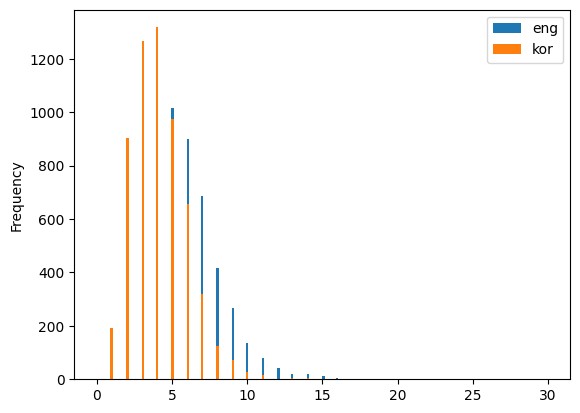

In [11]:
# 데이터 시각화를 위해 텍스트를 데이터 프레임을 변환한다.
df = pd.DataFrame({'eng':eng_l, 'kor':kor_l})
df.plot.hist(bins = 200, range=[0, 30])

한국어 문장의 최대 길이는 15이고 영어는 20이다.

- 문장을 정수인코딩
- 길이를 동일하게 패딩(padding)

In [12]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [13]:
# prepare english tokenizer
# 우선 영어를 먼저 토큰화
eng_tokenizer = tokenization(kor_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 20
print('영어 어휘 크기: %d 이다.' % eng_vocab_size)

영어 어휘 크기: 3189 이다.


In [14]:
# prepare Korean tokenizer
# 한글 토큰
kor_tokenizer = tokenization(kor_eng[:, 1])
kor_vocab_size = len(kor_tokenizer.word_index) + 1

kor_length = 20
print('한글 토큰 개수는 : %d' % kor_vocab_size)

한글 토큰 개수는 : 7949


- 데이터를 훈련 세트와 테스트 세트

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(kor_eng, test_size=0.2)

In [16]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [17]:
trainX = encode_sequences(kor_tokenizer, kor_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [18]:
testX = encode_sequences(kor_tokenizer, kor_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [19]:
print('훈련용 인코더 테이터 크기: ', trainX.shape)
print('훈련용 디코더 데이터 크기: ', trainY.shape)
print('테스트 인코더 테이터 크기: ', testX.shape)
print('테스트 디코더 데이터 크기: ', testY.shape)

훈련용 인코더 테이터 크기:  (4712, 20)
훈련용 디코더 데이터 크기:  (4712, 20)
테스트 인코더 테이터 크기:  (1178, 20)
테스트 디코더 데이터 크기:  (1178, 20)


- Seq2Seq 모델로 인코더에 LSTM층, 디코더에 LSTM 층

In [20]:
num_hiddens = 64

In [21]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units))
    model.add(LSTM(num_hiddens))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(num_hiddens, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [22]:
# 파라미터 개수 확인
print('kor_vocab_size: ', kor_vocab_size)
print('eng_vocab_size: ', eng_vocab_size)
print('kor_length: ', kor_length)
print('eng_length: ', eng_length)
print('히든 스테이트 뉴런: ', num_hiddens)

kor_vocab_size:  7949
eng_vocab_size:  3189
kor_length:  20
eng_length:  20
히든 스테이트 뉴런:  64


In [23]:
model = build_model(kor_vocab_size, eng_vocab_size, kor_length, eng_length, num_hiddens)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc'])

In [24]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=20, batch_size=16,
          validation_split = 0.2,  verbose=1)

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - acc: 0.7097 - loss: 4.3546 - val_acc: 0.7221 - val_loss: 2.0203
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - acc: 0.7322 - loss: 1.9130 - val_acc: 0.7314 - val_loss: 1.9499
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - acc: 0.7423 - loss: 1.8343 - val_acc: 0.7350 - val_loss: 1.9304
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - acc: 0.7421 - loss: 1.8151 - val_acc: 0.7337 - val_loss: 1.9207
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - acc: 0.7446 - loss: 1.7798 - val_acc: 0.7350 - val_loss: 1.9166
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - acc: 0.7442 - loss: 1.7853 - val_acc: 0.7350 - val_loss: 1.9166
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - acc: 0.7468 - loss: 1.7558 - val_acc: 0.7350 - val_loss: 1.9164
Epoch 8/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - acc: 0.7429 - loss: 1.7805 - val_acc: 0.7350 - val_loss: 1.9178
Epoch 9/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

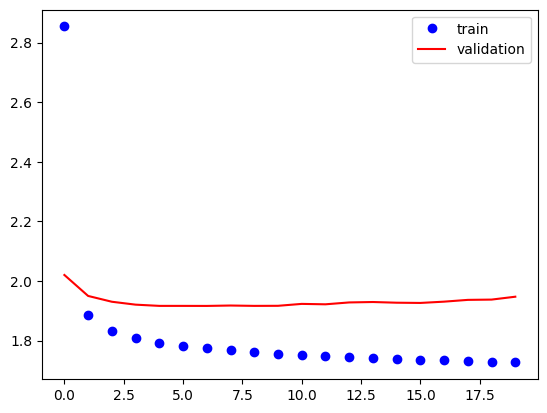

In [26]:
plt.plot(history.history['loss'],'bo')
plt.plot(history.history['val_loss'],'r')
plt.legend(['train','validation'])
plt.show()

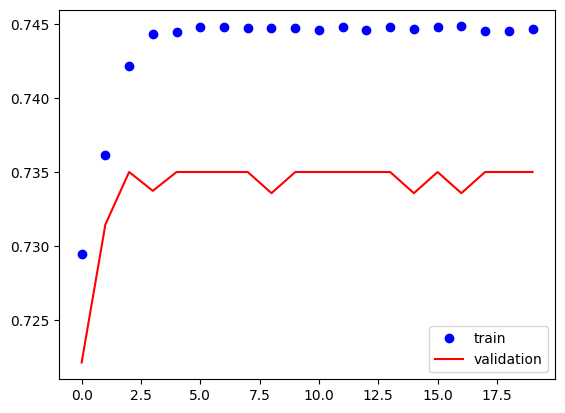

In [27]:
plt.plot(history.history['acc'],'bo')
plt.plot(history.history['val_acc'],'r')
plt.legend(['train','validation'])
plt.show()

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 64)              │         508,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20, 3189)            │         207,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,346,209 (8.95 MB)

 Trainable params: 782,069 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,564,140 (5.97 MB)